In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import classification_report

In [86]:
# read csv file into df
churn_raw_df = pd.read_csv('../Resources/telecom_customer_churn.csv')
churn_raw_df.head()

target_names = ['Stayed', 'Churned']


In [75]:
list(churn_raw_df.columns)

['Customer ID',
 'Gender',
 'Age',
 'Married',
 'Number of Dependents',
 'City',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Number of Referrals',
 'Tenure in Months',
 'Offer',
 'Phone Service',
 'Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'Customer Status',
 'Churn Category',
 'Churn Reason']

In [76]:
# Pre-processing of numerical variables for feature selection

# Prepare the data:
selection_data_raw = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df['Customer Status'] == 'Churned'), ['Customer ID', 'Age', 'Number of Dependents', 'Number of Referrals', 
    'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue', 'Customer Status']].dropna()
selection_data = pd.get_dummies(selection_data_raw, columns=['Customer Status'])
selection_data = selection_data.drop(columns='Customer Status_Churned')

# Numerical values of interest:
feature_selection = selection_data[['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 
    'Total Long Distance Charges', 'Total Revenue']]

# Convert y to 1D array for feature selection:
y_column = selection_data[['Customer Status_Stayed']]
y_selection = np.ravel(y_column)

# view dataframe:
selection_data


,Customer ID,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Long Distance Charges,Total Revenue,Customer Status_Stayed
0,0002-ORFBO,37,0,2,9,42.39,16.0,65.60,593.30,381.51,974.81,1
1,0003-MKNFE,46,0,0,9,10.69,10.0,-4.00,542.40,96.21,610.28,1
2,0004-TLHLJ,50,0,0,4,33.65,30.0,73.90,280.85,134.60,415.45,0
3,0011-IGKFF,78,0,1,13,27.82,4.0,98.00,1237.85,361.66,1599.51,0
4,0013-EXCHZ,75,0,3,3,7.38,11.0,83.90,267.40,22.14,289.54,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7035,9979-RGMZT,20,0,0,7,36.49,42.0,94.05,633.45,255.43,888.88,1
7036,9985-MWVIX,53,0,0,1,42.09,9.0,70.15,70.15,42.09,112.24,0
7038,9987-LUTYD,20,0,0,13,46.68,59.0,55.15,742.90,606.84,1349.74,1
7039,9992-RRAMN,40,0,1,22,16.20,17.0,85.10,1873.70,356.40,2230.10,0


In [77]:
# Classification Feature Selection of the numerical variables against the target (categorical variable)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

# ANOVA f-test Feature selection
    # ANOVA: analysis of variance. A test for determining whether the means from two or more samples of data come from the
        # same distribution
    # ANOVA is used when one variable is numeric and one is categorical
    # The methods based on F-test estimate the degree of linear dependency between two random variables
    # The result tells us which features are independent to the target variable

# define feature selection:
    # Select features according to the k highest scores
    # k=5 instructs the variable function to select the (5 best) features that are the most linearly dependent with the target
    # f_classif function computes the ANOVA f-score
fs = SelectKBest(score_func=f_classif, k=5)

# apply feature selection:
fs.fit(feature_selection, y_selection)
selected_features = fs.transform(feature_selection)

# tabulate features and view dataframe:
numerical_features_df = pd.DataFrame({'numerical_features': feature_selection.columns, 
    'KBest_to_keep': fs.get_support(), 'f-score': fs.scores_})
numerical_features_df


,numerical_features,KBest_to_keep,f-score
0,Age,False,41.842199
1,Number of Dependents,False,274.060250
2,Number of Referrals,True,626.890569
3,Tenure in Months,True,1314.420596
4,Avg Monthly Long Distance Charges,False,0.053871
5,Avg Monthly GB Download,False,46.029920
6,Monthly Charge,False,0.047848
7,Total Charges,True,883.880365
8,Total Long Distance Charges,True,556.228433
9,Total Revenue,True,917.283010


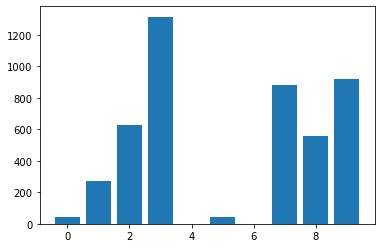

In [78]:
# plot:
pyplot.bar([i for i in range(len(numerical_features_df['f-score']))], height=numerical_features_df['f-score'])
pyplot.show()

In [79]:
# grab the best numerical features and customer ID as reference
selected_num_features = selection_data[['Customer ID', 'Number of Referrals', 'Tenure in Months', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue']]

# grab target variable and customer ID as reference
y_df = selection_data[['Customer ID', 'Customer Status_Stayed']]


#################################
# first KNN test: using only numerical variables for its features
#################################

# Prepare the data:
# merge data where selected_num_features['Customer ID']=y_df['Customer ID']
knn_1_df = pd.merge(selected_num_features, y_df, on=['Customer ID']).drop(['Customer ID'], axis=1)

# Assign X (numerical features) and y (target: Customer Status_Stayed)
y_knn_1 = knn_1_df[['Customer Status_Stayed']]
X_knn_1 = knn_1_df.drop('Customer Status_Stayed', axis=1)

# Split data into train and test sets:
# In specifying a stratify value we instruct the model to ensure that those relative class frequencies is approximately preserved in the train and test sets.
X_train_knn_1, X_test_knn_1, y_train_knn_1, y_test_knn_1 = train_test_split(X_knn_1, y_knn_1, random_state=42, test_size=0.2, stratify=y_knn_1)



In [80]:
# Normalize the features of our dataset using MinMaxScaler

# fit scaler on training data

X_norm_knn_1 = MinMaxScaler().fit(X_train_knn_1)

# Step 2: Transform the training data
X_train_norm_knn_1 = X_norm_knn_1.transform(X_train_knn_1)

# Step 3: Transform the testing data
X_test_norm_knn_1 = X_norm_knn_1.transform(X_test_knn_1)


In [81]:
# Define the model:
knn_model = KNeighborsClassifier()

# (tune) the model with GridSearch and Stratify kfold:

# key parameters:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# store parameters in parameter object:
param_grid_knn = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

cv_knn = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search estimator:
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, n_jobs=-1, cv=cv_knn, scoring='accuracy', error_score=0)

# fit the grid search using the grid search estimator with the train data:
# This will take the KNN model and try each combination of parameters
grid_result_knn = grid_search_knn.fit(X_train_norm_knn_1, y_train_knn_1)

# summarize results
print("Test Accuracy: %f, Grid Result: %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means_knn = grid_result_knn.cv_results_['mean_test_score']
stds_knn = grid_result_knn.cv_results_['std_test_score']
params_knn = grid_result_knn.cv_results_['params']
for mean, stdev, param in zip(means_knn, stds_knn, params_knn):
    print("%f (%f) with: %r" % (mean, stdev, param))


Test Accuracy: 0.795833, Grid Result: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}
0.759601 (0.019479) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.759601 (0.019479) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.769384 (0.020210) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.768569 (0.019293) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.779620 (0.019168) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.775996 (0.019478) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.780525 (0.022394) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.782790 (0.018416) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.782609 (0.020335) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.786775 (0.018639) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'dis

/Users/kinlaydenning/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

      Stayed       0.74      0.56      0.64       317
     Churned       0.80      0.89      0.84       604

    accuracy                           0.78       921
   macro avg       0.77      0.73      0.74       921
weighted avg       0.78      0.78      0.77       921



/Users/kinlaydenning/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


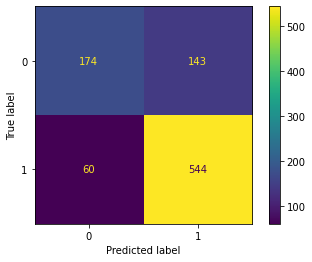

In [87]:
# Using the optimal parameters obtained by our gridsearch we can re-define the model:
knn_1_tuned_model = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 17, weights = 'distance')

# pass in train data to .fit() to train our knn model: 
knn_1_tuned_model.fit(X_train_norm_knn_1, y_train_knn_1)

# How accurate is the model in predicting the target class?
    # use the .predict() method and store the predicted values for the input values in the X_test_lr set
pred_class_test_knn_1 = knn_1_tuned_model.predict(X_test_norm_knn_1)

# Plot Confusion Matrix:
plot_confusion_matrix(grid_search_knn, X_test_norm_knn_1, y_test_knn_1, values_format='d')

# Print Classification Report:
print(classification_report(y_test_knn_1, pred_class_test_knn_1,
                            target_names=target_names)) 

In [8]:
# Feature Selection of Categorical Variables:
    # The idea: use the features that are correlated to the target when training the model
    # https://towardsdatascience.com/statistics-in-python-using-chi-square-for-feature-selection-d44f467ca745

# Chi-square test of independence
# How to determine whether two categorical variables have a significant relationship
    # chi-square is a way to check the relationship between two categorical nominal variables
    # The key idea behind the chi-square test is to compare the observed values in the data to the expected values and see if they are related or not.

#  Defining the hypothesis
# Null Hypothesis: The categorical variables to be compared are independent of each other
# Alternative Hypothesis: The categorical variables being compared are dependent on each other

# P-value:
# https://pythonguides.com/python-scipy-chi-square-test/
# The way we can quantifiably test the existance of a relationship is by obtaining a p-value. 
# A p-value is used to measure the significance of the results of the chi-square test 

# Based on the following p-value conditions, we can draw the following conclusions 
# p < 0.05 means the two categorical variables are correlated
# p > 0.05 means the two categorical variables are not correlated


# Chi-Squared Function
def chi2_function(contingency_table):    
    #---calculate degree of freedom---
    degree_f = (contingency_table.shape[0]-1) * (contingency_table.shape[1]-1)

    #---create the expected value dataframe---
    df_exp = contingency_table.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(contingency_table.sum(1)
        .values,contingency_table.sum().values) / contingency_table.sum().sum()            
    print('---Expected (E)---')
    display(df_exp)

    # calculate chi-square values
    chi2_df = ((contingency_table - df_exp)**2) / df_exp    
    chi2_df.loc[:,'Total']= chi2_df.sum(axis=1)
    chi2_df.loc['Total']= chi2_df.sum()
    print('---Chi-Square---')
    display(chi2_df)

    #---get chi-square score---   
    chi_square_score = chi2_df.iloc[:-1,:-1].sum().sum()
    
    #---calculate the p-value---
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    return chi_square_score, degree_f, p

In [33]:
# How gender (feature) is related to customer status (target)
sex_churn_df_complete = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df["Customer Status"] == 'Churned'), ['Customer ID', 'Gender']]

# merge data where sex_churn_df['Customer ID']=selection_data_raw['Customer ID']
sex_churn_merge = pd.merge(selection_data, sex_churn_df_complete, on=['Customer ID'])

print(len(selection_data))
print(len(sex_churn_merge))
sex_churn_merge

# Sex vs Churn Contingency Table
# Frequency Distribution of sex and customer status
sex_churn = sex_churn_merge.groupby(['Gender', 'Customer Status_Stayed'])['Gender'].count().unstack()

sex_churn_totals = sex_churn.copy()
sex_churn_totals.loc['Total']= sex_churn_totals.sum(numeric_only=True, axis=0)
sex_churn_totals.loc[:,'Total'] = sex_churn_totals.sum(numeric_only=True, axis=1)
sex_churn_totals



4601
4601


Customer Status_Stayed,0,1,Total
Gender,,,
Female,803,1499,2302
Male,783,1516,2299
Total,1586,3015,4601


In [34]:
# Null Hypothesis: Sex and customer status are independent (uncorrelated)

# Alternate Hypothesis: Sex and customer status are dependent (correlated)

# Call chi2_function:
chi2_function(sex_churn)

# Interpretation:
# The sex of customer is independent or unrelated to whether a customer churned (0) customer stayed (1).
# do we still use it?


---Expected (E)---


Customer Status_Stayed,0,1
Gender,,
Female,793.517062,1508.482938
Male,792.482938,1506.517062


---Chi-Square---


Customer Status_Stayed,0,1,Total
Gender,,,
Female,0.113326,0.059614,0.172940
Male,0.113474,0.059691,0.173165
Total,0.226800,0.119305,0.346105


(0.3461049232464444, 1, 0.5563263637061033)

In [35]:
# How marriage status (feature) is related to customer status (target)
marriage_df_complete = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df['Customer Status'] == 'Churned'), ['Customer ID', 'Married']]

# merge data where sex_churn_df['Customer ID']=selection_data_raw['Customer ID']
marriage_df_merge = pd.merge(selection_data, marriage_df_complete, on=['Customer ID'])
print(len(selection_data))
print(len(marriage_df_merge))

# Marriage vs Churn Contingency Table
# Frequency Distribution of marital status and customer status
marriage_churn = marriage_df_merge.groupby(['Married', 'Customer Status_Stayed'])['Married'].count().unstack()

# Contingency table with totals
marriage_churn_totals = marriage_churn.copy()
marriage_churn_totals.loc['Total']= marriage_churn_totals.sum(numeric_only=True, axis=0)
marriage_churn_totals.loc[:,'Total'] = marriage_churn_totals.sum(numeric_only=True, axis=1)

marriage_churn_totals


4601
4601


Customer Status_Stayed,0,1,Total
Married,,,
No,1007,1282,2289
Yes,579,1733,2312
Total,1586,3015,4601


In [36]:
# Null Hypothesis: Marriage status and customer status are independent (uncorrelated)

# Alternate Hypothesis: Marriage status and customer status are dependent (correlated)

# Call chi2_function:
chi2_function(marriage_churn)

# Interpretation:
# P > 0.05, Marriage status and customer status are independent (uncorrelated).


---Expected (E)---


Customer Status_Stayed,0,1
Married,,
No,789.035862,1499.964138
Yes,796.964138,1515.035862


---Chi-Square---


Customer Status_Stayed,0,1,Total
Married,,,
No,60.210654,31.673001,91.883655
Yes,59.611673,31.357915,90.969588
Total,119.822327,63.030916,182.853243


(182.85324309790312, 1, 1.154696955364568e-41)

In [42]:
# Contract type vs customer status
contract_df_complete = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df['Customer Status'] == 'Churned'), ['Customer ID','Contract']]
contract_df_merge = pd.merge(selection_data, contract_df_complete, on=['Customer ID'])
print(len(selection_data))
print(len(contract_df_merge))

# Contingency table for chi2 function
# Contract type vs Churn Contingency Table
    # Frequency distribution of contract type and customer status
contract_churn = contract_df_merge.groupby(['Contract', 'Customer Status_Stayed'])['Contract'].count().unstack()

# Contingency table with totals
contract_churn_totals = contract_churn.copy()
contract_churn_totals.loc['Total']= contract_churn_totals.sum(numeric_only=True, axis=0)
contract_churn_totals.loc[:,'Total'] = contract_churn_totals.sum(numeric_only=True, axis=1)
contract_churn_totals


4601
4601


Customer Status_Stayed,0,1,Total
Contract,,,
Month-to-Month,1403,1128,2531
One Year,143,883,1026
Two Year,40,1004,1044
Total,1586,3015,4601


In [43]:
# Null Hypothesis: contract type and customer status are independent (uncorrelated)

# Alternate Hypothesis: contract type and customer status are dependent (correlated)

# Call chi2_function:
chi2_function(contract_churn)

# Interpretation: P > 0.05, contract type and customer status are independent (uncorrelated).


---Expected (E)---


Customer Status_Stayed,0,1
Contract,,
Month-to-Month,872.455118,1658.544882
One Year,353.670072,672.329928
Two Year,359.874810,684.125190


---Chi-Square---


Customer Status_Stayed,0,1,Total
Contract,,,
Month-to-Month,322.627337,169.713750,492.341087
One Year,125.489496,66.012053,191.501550
Two Year,284.320800,149.563114,433.883915
Total,732.437633,385.288918,1117.726551


(1117.7265509272606, 2, 1.9443002309889068e-243)

In [46]:
# Made referal (convert to binary) vs customer status
referral_df_complete = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df['Customer Status'] == 'Churned'), ['Customer ID', 'Number of Referrals']]
referral_df_complete["Made Referral"] = (referral_df_complete['Number of Referrals'] > 0).astype(int)

referral_df_merge = pd.merge(selection_data, referral_df_complete, on=['Customer ID'])
print(len(selection_data))
print(len(referral_df_merge))

# Contingency table for chi2 function
# Made referal vs Churn Contingency Table
    # Frequency distribution of customers who made a referral and customer status
referral_churn = referral_df_merge.groupby(['Made Referral', 'Customer Status_Stayed'])['Made Referral'].count().unstack()

# Contingency table with totals
referral_churn_totals = referral_churn.copy()
referral_churn_totals.loc['Total']= referral_churn_totals.sum(numeric_only=True, axis=0)
referral_churn_totals.loc[:,'Total'] = referral_churn_totals.sum(numeric_only=True, axis=1)
referral_churn_totals


4601
4601


Customer Status_Stayed,0,1,Total
Made Referral,,,
0,1047,1361,2408
1,539,1654,2193
Total,1586,3015,4601


In [47]:
# Null Hypothesis: Customers who made a referral and customer status are independent (uncorrelated)

# Alternate Hypothesis: Customers who made a referral and customer status are dependent (correlated)

# Call chi2_function:
chi2_function(referral_churn)

# Interpretation:
# P > 0.05, Referral status and customer status are independent (uncorrelated).

---Expected (E)---


Customer Status_Stayed,0,1
Made Referral,,
0,830.056075,1577.943925
1,755.943925,1437.056075


---Chi-Square---


Customer Status_Stayed,0,1,Total
Made Referral,,,
0,56.700587,29.826577,86.527164
1,62.259468,32.750752,95.010220
Total,118.960055,62.577329,181.537384


(181.5373842700415, 1, 2.2374568579092315e-41)

In [49]:
# Premium Tech support vs customer status
tech_support_df_complete = churn_raw_df.loc[(churn_raw_df['Customer Status'] == 'Stayed') | (churn_raw_df['Customer Status'] == 'Churned'), ['Customer ID', 'Premium Tech Support']]

tech_support_df_merge = pd.merge(selection_data, tech_support_df_complete, on=['Customer ID'])
print(len(selection_data))
print(len(tech_support_df_merge))

# Contingency table for chi2 function
# Has Tech Support vs Churn Contingency Table
    # Frequency distribution of customers with tech support and customer status
tech_support_churn = tech_support_df_merge.groupby(['Premium Tech Support', 'Customer Status_Stayed'])['Premium Tech Support'].count().unstack()

# Contingency table with totals
tech_support_totals = tech_support_churn.copy()
tech_support_totals.loc['Total']= tech_support_totals.sum(numeric_only=True, axis=0)
tech_support_totals.loc[:,'Total'] = tech_support_totals.sum(numeric_only=True, axis=1)
tech_support_totals


4601
4601


Customer Status_Stayed,0,1,Total
Premium Tech Support,,,
No,1304,1579,2883
Yes,282,1436,1718
Total,1586,3015,4601


In [50]:
# Null Hypothesis: customers with tech support and customer status are independent (uncorrelated)

# Alternate Hypothesis: customers with tech support and customer status are dependent (correlated)

# Call chi2_function:
chi2_function(tech_support_churn)

# Interpretation: P < 0.05, customers with tech support and customer status are independent (uncorrelated) 

---Expected (E)---


Customer Status_Stayed,0,1
Premium Tech Support,,
No,993.792219,1889.207781
Yes,592.207781,1125.792219


---Chi-Square---


Customer Status_Stayed,0,1,Total
Premium Tech Support,,,
No,96.829967,50.936095,147.766062
Yes,162.491731,85.476579,247.968310
Total,259.321697,136.412674,395.734371


(395.73437139795965, 1, 4.6721920395149786e-88)

In [16]:
# Churn Category:

churn_category_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Churned"), ["Customer ID", "Customer Status", "Churn Category"]]
category_of_churn = churn_category_df.groupby(["Customer Status", "Churn Category"])["Customer ID"].count().unstack()
category_of_churn

Churn Category,Attitude,Competitor,Dissatisfaction,Other,Price
Customer Status,,,,,
Churned,314,841,321,182,211


In [27]:
# Churn Reason:

churn_reason_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Churned"), ["Customer ID", "Customer Status", "Churn Reason"]]
churn_reason_df["Churn Reason"].value_counts()


Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: Churn Reason, 

In [17]:
# Tenure in months (bins transfromation) vs customer status

In [18]:
# Has dependents (binary transformation) vs customer status

In [19]:
# Churn Category

# offer vs customer status

offer_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Stayed") | (churn_raw_df["Customer Status"] == "Churned"), ["Customer Status", "Offer"]]
offer_vs_status = offer_df.groupby(["Customer Status", "Offer"])["Customer Status"].count().unstack()
offer_vs_status


Offer,None,Offer A,Offer B,Offer C,Offer D,Offer E
Customer Status,,,,,,
Churned,1051,35,101,95,161,426
Stayed,2547,485,723,320,441,204


In [20]:
# total rev rounded

total_rev_offer_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Stayed") | (churn_raw_df["Customer Status"] == "Churned"), ["Total Revenue", "Offer", "Customer Status"]]
total_rev_offer_df["Total Revenue Rounded"] = round(total_rev_offer_df["Total Revenue"],-3)
totaldf = total_rev_offer_df.groupby(["Offer", "Customer Status", "Total Revenue Rounded"])["Total Revenue Rounded"].count().unstack()
totaldf

Total Revenue Rounded    0.0      1000.0   2000.0   3000.0   4000.0   5000.0   \
Offer   Customer Status                                                         
None    Churned            392.0    229.0    121.0     79.0     70.0     43.0   
        Stayed             227.0    498.0    423.0    330.0    245.0    182.0   
Offer A Churned              NaN      NaN      NaN      NaN      1.0      NaN   
        Stayed               NaN      NaN     25.0     47.0     44.0     36.0   
Offer B Churned              NaN      1.0      9.0      7.0      2.0     20.0   
        Stayed               NaN     25.0     93.0     97.0     82.0    115.0   
Offer C Churned              NaN      7.0      8.0     39.0     26.0     12.0   
        Stayed               1.0     78.0     73.0     93.0     54.0     20.0   
Offer D Churned              6.0     79.0     63.0     13.0      NaN      NaN   
        Stayed              49.0    252.0    117.0     23.0      NaN      NaN   
Offer E Churned            344.0     82.0      NaN      NaN      NaN      NaN   
        Stayed             121.0     83.0      NaN      NaN      NaN      NaN   

Total Revenue Rounded    6000.0   7000.0   8000.0   9000.0   10000.0  11000.0  \
Offer   Customer Status                                                         
None    Churned             35.0     29.0     26.0     17.0      6.0      4.0   
        Stayed             157.0    164.0    137.0     92.0     69.0     19.0   
Offer A Churned              NaN      3.0     11.0     13.0      3.0      4.0   
        Stayed              34.0     66.0     75.0     71.0     55.0     26.0   
Offer B Churned             27.0     19.0     12.0      4.0      NaN      NaN   
        Stayed             115.0     94.0     65.0     29.0      8.0      NaN   
Offer C Churned              3.0      NaN      NaN      NaN      NaN      NaN   
        Stayed               1.0      NaN      NaN      NaN      NaN      NaN   
Offer D Churned              NaN      NaN      NaN      NaN      NaN      NaN   
        Stayed               NaN      NaN      NaN      NaN      NaN      NaN   
Offer E Churned              NaN      NaN      NaN      NaN      NaN      NaN   
        Stayed               NaN      NaN      NaN      NaN      NaN      NaN   

Total Revenue Rounded    12000.0  
Offer   Customer Status           
None    Churned              NaN  
        Stayed               4.0  
Offer A Churned              NaN  
        Stayed               6.0  
Offer B Churned              NaN  
        Stayed               NaN  
Offer C Churned              NaN  
        Stayed               NaN  
Offer D Churned              NaN  
        Stayed               NaN  
Offer E Churned              NaN  
        Stayed               NaN

In [21]:
f = total_rev_offer_df.groupby(["Customer Status", "Total Revenue Rounded"])["Customer Status"].count().unstack()
f

Total Revenue Rounded,0.0,1000.0,2000.0,3000.0,4000.0,5000.0,6000.0,7000.0,8000.0,9000.0,10000.0,11000.0,12000.0
Customer Status,,,,,,,,,,,,,
Churned,742.0,398.0,201.0,138.0,99.0,75.0,65.0,51.0,49.0,34.0,9.0,8.0,NaN
Stayed,398.0,936.0,731.0,590.0,425.0,353.0,307.0,324.0,277.0,192.0,132.0,45.0,10.0
